# CIFAR DP-SGD example

This code runs CIFAR10 and CIFAR100 under DP-sgd. To switch between these two datasets, update the `dataset` field in `train_config_dpsgd.yaml` and the `data_path` field in `audit.yaml` accordingly.


##### Make sure opacus is installed

In [1]:
!pip install opacus

In [2]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)

Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [3]:

from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open('train_config_dpsgd.yaml', 'r') as file:
    train_config = yaml.safe_load(file)
    
root = train_config["data"]["data_dir"]
path = os.path.join(os.getcwd(), root)
# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=root, train=True, download=True)
    testset = CIFAR10(root=root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=root, train=True, download=True)
    testset = CIFAR100(root=root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro
dataset_name = train_config["data"]["dataset"]
file_path =  "data/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [4]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

# Evaluate mean and variance of the train data
train_mean = train_subset.mean
train_std = train_subset.std
print (f"Train mean: {train_mean}, Train std: {train_std}")

Train mean: tensor([[[0.5000]],

        [[0.4914]],

        [[0.4557]]]), Train std: tensor([[[0.2492]],

        [[0.2460]],

        [[0.2637]]])



## Noise Multiplier Configuration for Privacy Analysis

In this code block, we configure the parameters necessary for calculating the noise multiplier using the **Ocapi** library, which we used for differential privacy analysis. 

- **`target_epsilon`**: The desired epsilon value.
- **`target_delta`**: The delta value indicating the risk of privacy loss.
- **`sample_rate`**: The rate at which data points are used in training.
- **`epochs`**: The number of training epochs for the model.
- **`epsilon_tolerance`**: A small margin for the epsilon value,
- **`accountant`**: Specifies the method of tracking privacy loss, with "prv" referring to the Privacy Accountant for DPSGD.
- **`eps_error`**: The allowable error in epsilon calculations
- **`max_grad_norm`**: A limit on the gradient norm to ensure the gradients do not explode during training.

The most common hyperparameters to tune are `target_epsilon`, `sample_rate`, `noise_multiplier`, and `max_grad_norm`. These parameters should be inputed by the user based on thier need for balancing privacy and utility.


In [5]:
target_model_dir = "./target_dpsgd"
delta = 1e-5
target_epsilon = 3.5
sample_rate = 1/len(train_loader) # already incorporates batchsize
    
noise_multiplier_dict = {
    "target_epsilon": target_epsilon,
    "target_delta": delta,
    "sample_rate": sample_rate,
    "epochs": 20,
    "epsilon_tolerance": 0.01,
    "accountant": "prv",
    "eps_error": 0.01,
    "max_grad_norm": 1.2,
}

# Create metadata for privacy engine
with open(f"{target_model_dir}/dpsgd_dic.pkl", "wb") as f:
    pickle.dump(noise_multiplier_dict, f)

In [6]:
from torch import save, optim, nn

# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
momentum = train_config["train"]["momentum"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()

## Import the DP-SGD versions of the model and inputhandler

### Since shadow models can inherit init params of the target we can use that for different cases   
    1. No DP-SGD for target model and shadow models:  
model = ResNet18_DPsgd(dpsgd=False)  

    2. DP-SGD for target model and shadow models:  
model = ResNet18_DPsgd(dpsgd=True)  
  
    or change the flag:  
model.dpsgd = True

In [7]:
from cifar_handler_dpsgd import CifarInputHandlerDPsgd
from target_model_class import ResNet18_DPsgd

# Create instance of DP-compliant target model
model = ResNet18_DPsgd(
                    num_classes = num_classes,
                    dpsgd=True,
                    )

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# train target model
train_result = CifarInputHandlerDPsgd().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)

# Get the trained DP-sgd model
model = train_result.model

# Evaluate on test set
test_result = CifarInputHandlerDPsgd().eval(test_loader, model, criterion)

# Store the model and metadata
model.to("cpu")

# To be able to later load the DP-compliant target model, we need to clean the state dict
state_dict = model.state_dict()

with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(
                                    train_result = train_result,
                                    optimizer = optimizer,
                                    loss_fn = criterion,
                                    dataloader = train_loader,
                                    test_result = test_result,
                                    epochs = epochs,
                                    train_indices = train_indices,
                                    test_indices = test_indices,
                                    dataset_name = dataset_name
                                    )

with open("target_dpsgd/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)
    

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
2025-04-29 08:59:46,114 INFO     Training with DP-SGD
04/29/2025 08:59:46:INFO:Training with DP-SGD
2025-04-29 08:59:46,117 INFO     Pickle file loaded successfully, using DPsgd config:
04/29/2025 08:59:46:INFO:Pickle file loaded successfully, using DPsgd config:
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/us

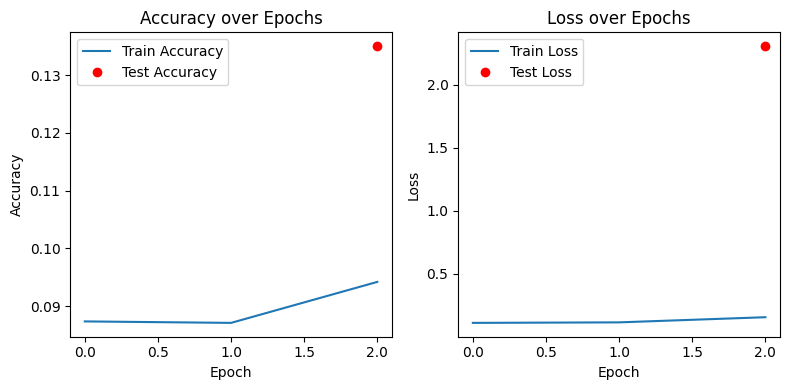

In [8]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from leakpro import LeakPro

# Read the DPsgd config file and prepare LeakPro object for DPsgd
config_path = "audit_dpsgd.yaml"
leakpro = LeakPro(CifarInputHandlerDPsgd, config_path)

# Run the audit 
mia_results_sgd = leakpro.run_audit(create_pdf=True)

2025-04-29 08:59:58,704 INFO     Target model blueprint created from ResNet18_DPsgd in ./target_model_class.py.
04/29/2025 08:59:58:INFO:Target model blueprint created from ResNet18_DPsgd in ./target_model_class.py.
2025-04-29 08:59:58,721 INFO     Loaded target model metadata from ./target_dpsgd/model_metadata.pkl
04/29/2025 08:59:58:INFO:Loaded target model metadata from ./target_dpsgd/model_metadata.pkl
2025-04-29 08:59:59,077 INFO     Loaded target model from ./target_dpsgd
04/29/2025 08:59:59:INFO:Loaded target model from ./target_dpsgd
2025-04-29 09:00:00,234 INFO     Loaded population dataset from ./data/cifar10.pkl
04/29/2025 09:00:00:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-04-29 09:00:00,237 INFO     Image extension initialized.
04/29/2025 09:00:00:INFO:Image extension initialized.
2025-04-29 09:00:00,317 INFO     MIA attack factory loaded.
04/29/2025 09:00:00:INFO:MIA attack factory loaded.
2025-04-29 09:00:00,319 INFO     Creating shadow model handler sin

<Figure size 640x480 with 0 Axes>